# Compare the CIGALE results of EMU and non-EMU sources

In [62]:
observatory = '/data/mfonseca/'
my_computer = '/home/polaris/Lab_Astro/data/'

directory = my_computer

## Import Libraries

In [100]:
import numpy as np
import pandas as pd
import math


# Astropy
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
# Use the Planck 2020/2018 cosmology
from astropy.cosmology import Planck18 as cosmo

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Seaborn
import seaborn as sns

# Custom color palette
set2_colors = sns.color_palette('coolwarm')
custom_palette = [set2_colors[0], set2_colors[-1]]

sns.color_palette(custom_palette)

[(0.4044212904941176, 0.5346434904470588, 0.9320019126352941),
 (0.8846434386941177, 0.41001709788235297, 0.32250654924705885)]

## Import results files from EMU and non-EMU sources and select objects with x²_red < 5

In [64]:
emu_sources = pd.read_csv('/home/polaris/Lab_Astro/data/cigale/emu_data/out_withAGN_1/results.txt', sep='\s+')
nonemu_sources = pd.read_csv('/home/polaris/Lab_Astro/data/cigale/nonemu_data/nonemu_sample_1/results.txt', sep='\s+')
#nonemu_prototypes = pd.read_csv('/home/polaris/Lab_Astro/data/cigale/nonemu_data/prototypes/results.txt', sep='\s+')

Select EMU and non-EMU sources with a x²_red less than 5 , to analyse sources with a good fitting.

In [71]:
best_matches_emu = emu_sources['best.reduced_chi_square'] <= 5.0
emu_sources_best = emu_sources[best_matches_emu]
print(f'Number of emu objects with x²_red <= 5: {len(emu_sources_best)}')
emu_sources_best['bayes.sfh.sfr_permass'] =  emu_sources_best['bayes.sfh.sfr']/emu_sources_best['bayes.stellar.m_star']


best_matches_nonemu = nonemu_sources['best.reduced_chi_square'] > 0
nonemu_sources_best = nonemu_sources[best_matches_nonemu]
print(f'Number of non-emu objects with x²_red <= 5: {len(nonemu_sources_best)}')
nonemu_sources_best['bayes.sfh.sfr_permass'] =  nonemu_sources_best['bayes.sfh.sfr']/emu_sources_best['bayes.stellar.m_star']


# best_matches_nonemu_prots = nonemu_prototypes['best.reduced_chi_square'] <= 5.0
# nonemu_prototypes_best = nonemu_prototypes[best_matches_nonemu_prots]
# print(f'Number of non-emu prototypes with x²_red <= 5: {len(nonemu_prototypes_best)}')

Number of emu objects with x²_red <= 5: 3506
Number of non-emu objects with x²_red <= 5: 3530


/tmp/ipykernel_11329/2042961322.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emu_sources_best['bayes.sfh.sfr_permass'] =  emu_sources_best['bayes.sfh.sfr']/emu_sources_best['bayes.stellar.m_star']


## Average Values

In [66]:
def simple_avg_and_error(values, errors):
    values = np.asarray(values)
    
    avg = np.mean(values)
    avg_error = np.std(values)
    
    return avg, avg_error

In [67]:
# EMU
emu_avg_stellarmass, emu_err_stellarmass = simple_avg_and_error(emu_sources_best['bayes.stellar.m_star'], emu_sources_best['bayes.stellar.m_star_err'])
print(r'Stellar Mass:', f'{np.log10(emu_avg_stellarmass):.4f} ± {np.log10(emu_err_stellarmass):.4f}')

emu_avg_sfr, emu_err_sfr = simple_avg_and_error(emu_sources_best['bayes.sfh.sfr'], emu_sources_best['bayes.sfh.sfr_err'])
print(r'Star Formation Rate:', f'{np.log10(emu_avg_sfr):.4f} ± {np.log10(emu_err_sfr):.4f}')

emu_avg_ssfr, emu_err_ssfr = simple_avg_and_error(emu_sources_best['bayes.sfh.sfr']/emu_sources_best['bayes.stellar.m_star'], emu_sources_best['bayes.sfh.sfr_err']/emu_sources_best['bayes.stellar.m_star_err'])
print(r'Specific Star Formation Rate:', f'{np.log10(emu_avg_ssfr):.4f} ± {np.log10(emu_err_ssfr):.4f}')

emu_avg_metallicity, emu_err_metallicity = simple_avg_and_error(emu_sources_best['bayes.stellar.metallicity'], emu_sources_best['bayes.stellar.metallicity_err'])
print(r'Metallicity:', f'{emu_avg_metallicity:.4f} ± {emu_err_metallicity:.4f}')

emu_avg_age, emu_err_age = simple_avg_and_error(emu_sources_best['bayes.sfh.age'], emu_sources_best['bayes.sfh.age_err'])
print(r'Age:', f'{np.log10(emu_avg_age):.4f} ± {np.log10(emu_err_age):.4f}')

emu_avg_Av_BC, emu_err_Av_BC = simple_avg_and_error(emu_sources_best['bayes.attenuation.Av_BC'], emu_sources_best['bayes.attenuation.Av_BC_err'])
print(r'Av_BC:', f'{emu_avg_Av_BC:.4f} ± {emu_err_Av_BC:.4f}')

emu_avg_AGN, emu_err_AGN = simple_avg_and_error(emu_sources_best['bayes.agn.fracAGN'], emu_sources_best['bayes.agn.fracAGN_err'])
print(r'AGN Fraction:', f'{emu_avg_AGN:.4f} ± {emu_err_AGN:.4f}')

emu_avg_red, emu_err_red = simple_avg_and_error(emu_sources_best['bayes.universe.redshift'], emu_sources_best['bayes.universe.redshift_err'])
print(r'Redshift:', f'{emu_avg_red:.4f} ± {emu_err_red:.4f}')

Stellar Mass: 11.1692 ± 11.4512
Star Formation Rate: 2.6764 ± 3.5211
Specific Star Formation Rate: -8.7646 ± -8.3683
Metallicity: 0.0231 ± 0.0086
Age: 3.5774 ± 3.2190
Av_BC: 0.5038 ± 0.2867
AGN Fraction: 0.1952 ± 0.1228
Redshift: 0.6791 ± 0.4624


In [68]:
# Non-EMU
avg_stellarmass, err_stellarmass = simple_avg_and_error(nonemu_sources_best['bayes.stellar.m_star'], nonemu_sources_best['bayes.stellar.m_star_err'])
print(r'Stellar Mass:', f'{np.log10(avg_stellarmass):.4f} ± {np.log10(err_stellarmass):.4f}')

avg_sfr, err_sfr = simple_avg_and_error(nonemu_sources_best['bayes.sfh.sfr'], nonemu_sources_best['bayes.sfh.sfr_err'])
print(r'Star Formation Rate:', f'{np.log10(avg_sfr):.4f} ± {np.log10(err_sfr):.4f}')

avg_ssfr, err_ssfr = simple_avg_and_error(nonemu_sources_best['bayes.sfh.sfr']/nonemu_sources_best['bayes.stellar.m_star'], nonemu_sources_best['bayes.sfh.sfr_err']/nonemu_sources_best['bayes.stellar.m_star_err'])
print(r'Specific Star Formation Rate:', f'{np.log10(avg_ssfr):.4f} ± {np.log10(err_ssfr):.4f}')

avg_metallicity, err_metallicity = simple_avg_and_error(nonemu_sources_best['bayes.stellar.metallicity'], nonemu_sources_best['bayes.stellar.metallicity_err'])
print(r'Metallicity:', f'{avg_metallicity:.4f} ± {err_metallicity:.4f}')

avg_age, err_age = simple_avg_and_error(nonemu_sources_best['bayes.sfh.age'], nonemu_sources_best['bayes.sfh.age_err'])
print(r'Age:', f'{np.log10(avg_age):.4f} ± {np.log10(err_age):.4f}')

avg_Av_BC, err_Av_BC = simple_avg_and_error(nonemu_sources_best['bayes.attenuation.Av_BC'], nonemu_sources_best['bayes.attenuation.Av_BC_err'])
print(r'Av_BC:', f'{avg_Av_BC:.4f} ± {err_Av_BC:.4f}')

avg_AGN, err_AGN = simple_avg_and_error(nonemu_sources_best['bayes.agn.fracAGN'], nonemu_sources_best['bayes.agn.fracAGN_err'])
print(r'AGN Fraction:', f'{avg_AGN:.4f} ± {err_AGN:.4f}')

avg_red, err_red = simple_avg_and_error(nonemu_sources_best['bayes.universe.redshift'], nonemu_sources_best['bayes.universe.redshift_err'])
print(r'Redshift:', f'{avg_red:.4f} ± {err_red:.4f}')

Stellar Mass: 10.7752 ± 10.8945
Star Formation Rate: 1.4420 ± 2.1409
Specific Star Formation Rate: -8.9321 ± -8.4670
Metallicity: 0.0171 ± 0.0090
Age: 3.5527 ± 3.2835
Av_BC: 0.2735 ± 0.3009
AGN Fraction: 0.2506 ± 0.1239
Redshift: 0.5405 ± 0.3066


## Logarithmic values

In [74]:
# EMU
emu_sources_best['log_stellar_mass'] = np.log10(emu_sources_best['bayes.stellar.m_star'])
emu_sources_best['log_sfr'] = np.log10(emu_sources_best['bayes.sfh.sfr'])
emu_sources_best['log_ssfr'] = np.log10(emu_sources_best['bayes.sfh.sfr'] / emu_sources_best['bayes.stellar.m_star'])
emu_sources_best['log_metallicity'] = np.log10(emu_sources_best['bayes.stellar.metallicity'])
emu_sources_best['log_age'] = np.log10(emu_sources_best['bayes.sfh.age'])
emu_sources_best['log_attenuation'] = np.log10(emu_sources_best['bayes.attenuation.Av_BC'])

/tmp/ipykernel_11329/251453723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emu_sources_best['log_stellar_mass'] = np.log10(emu_sources_best['bayes.stellar.m_star'])
/tmp/ipykernel_11329/251453723.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emu_sources_best['log_sfr'] = np.log10(emu_sources_best['bayes.sfh.sfr'])
/tmp/ipykernel_11329/251453723.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [73]:
# NON EMU
nonemu_sources_best['log_stellar_mass'] = np.log10(nonemu_sources_best['bayes.stellar.m_star'])
nonemu_sources_best['log_sfr'] = np.log10(nonemu_sources_best['bayes.sfh.sfr'])
nonemu_sources_best['log_ssfr'] = np.log10(nonemu_sources_best['bayes.sfh.sfr'] / nonemu_sources_best['bayes.stellar.m_star'])
nonemu_sources_best['log_metallicity'] = np.log10(nonemu_sources_best['bayes.stellar.metallicity'])
nonemu_sources_best['log_age'] = np.log10(nonemu_sources_best['bayes.sfh.age'])
nonemu_sources_best['log_attenuation'] = np.log10(nonemu_sources_best['bayes.attenuation.Av_BC'])

## Compare EMU and non-EMU sources

### Diagonal Correlation Matrix

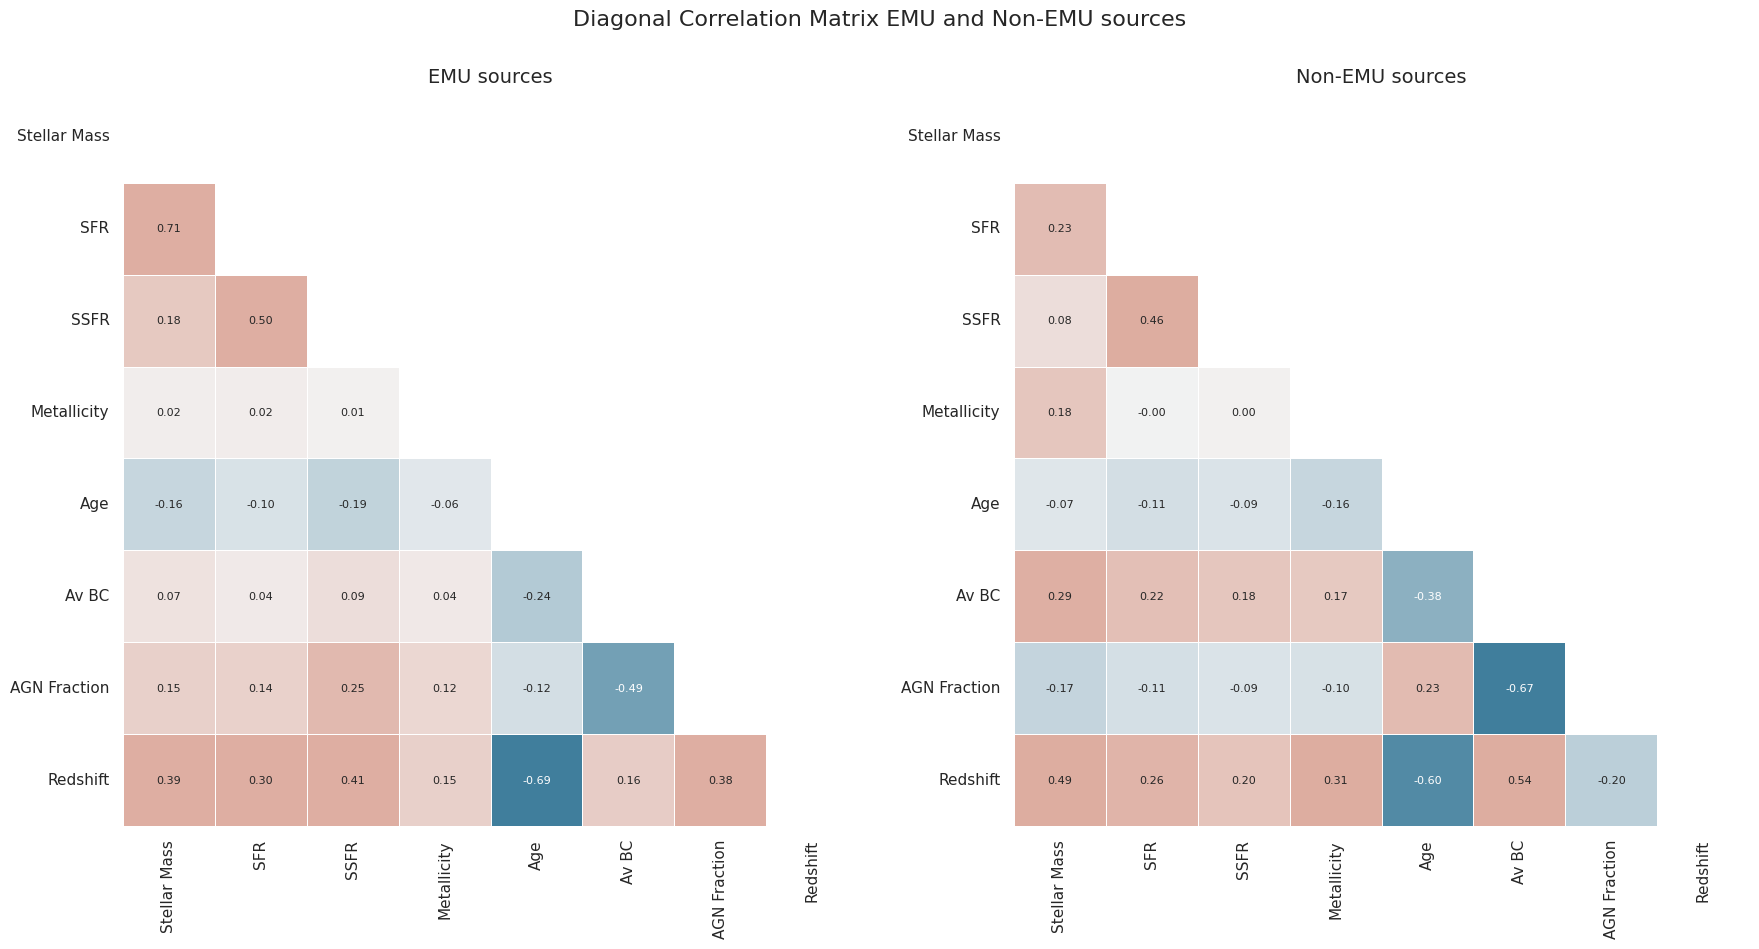

In [ ]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

emu_sources_best_cols = emu_sources_best[['bayes.stellar.m_star', 'bayes.sfh.sfr', 'bayes.sfh.sfr_permass', 'bayes.stellar.metallicity', 'bayes.sfh.age', 'bayes.attenuation.Av_BC', 'bayes.agn.fracAGN', 'bayes.universe.redshift']]
nonemu_sources_best_cols = nonemu_sources_best[['bayes.stellar.m_star', 'bayes.sfh.sfr', 'bayes.sfh.sfr_permass', 'bayes.stellar.metallicity', 'bayes.sfh.age', 'bayes.attenuation.Av_BC', 'bayes.agn.fracAGN', 'bayes.universe.redshift']]


new_column_labels = {
    'bayes.stellar.m_star': 'Stellar Mass',
    'bayes.sfh.sfr': 'SFR',
    'bayes.sfh.sfr_permass': 'SSFR',
    'bayes.stellar.metallicity': 'Metallicity',
    'bayes.sfh.age': 'Age',
    'bayes.attenuation.Av_BC': 'Av BC',
    'bayes.agn.fracAGN': 'AGN Fraction',
    'bayes.universe.redshift': 'Redshift'
}

# Compute the correlation matrix
emu_sources_best_cor = emu_sources_best_cols.corr()
nonemu_sources_best_cor = nonemu_sources_best_cols.corr()

# Rename the index and columns of the correlation matrices for display
emu_sources_best_cor = emu_sources_best_cor.rename(index=new_column_labels, columns=new_column_labels)
nonemu_sources_best_cor = nonemu_sources_best_cor.rename(index=new_column_labels, columns=new_column_labels)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(emu_sources_best_cor, dtype=bool))

# Set up the matplotlib figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

# Use this colormap
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(emu_sources_best_cor, mask=mask, cmap='cmap', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax1,
            cbar=False,  # Disable colorbar on individual heatmaps if you want a shared one later
            annot=True, fmt=".2f", # Add correlation values
            annot_kws={"size": 8}) # Adjust annotation font size
ax1.set_title('EMU sources', fontsize=14) # Set title for the first subplot

# Draw the second heatmap on ax2
sns.heatmap(nonemu_sources_best_cor, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax2,
            cbar=False, # Disable colorbar
            annot=True, fmt=".2f", # Add correlation values
            annot_kws={"size": 8}) # Adjust annotation font size
ax2.set_title('Non-EMU sources', fontsize=14) # Set title for the second subplot


plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust rect to make space for overall title if needed
plt.suptitle('Diagonal Correlation Matrix EMU and Non-EMU sources', fontsize=16, y=1.02) # Overall title

plt.show()


### Density plot

/tmp/ipykernel_11329/793647305.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emu_sources_best['dataset'] = 'EMU'


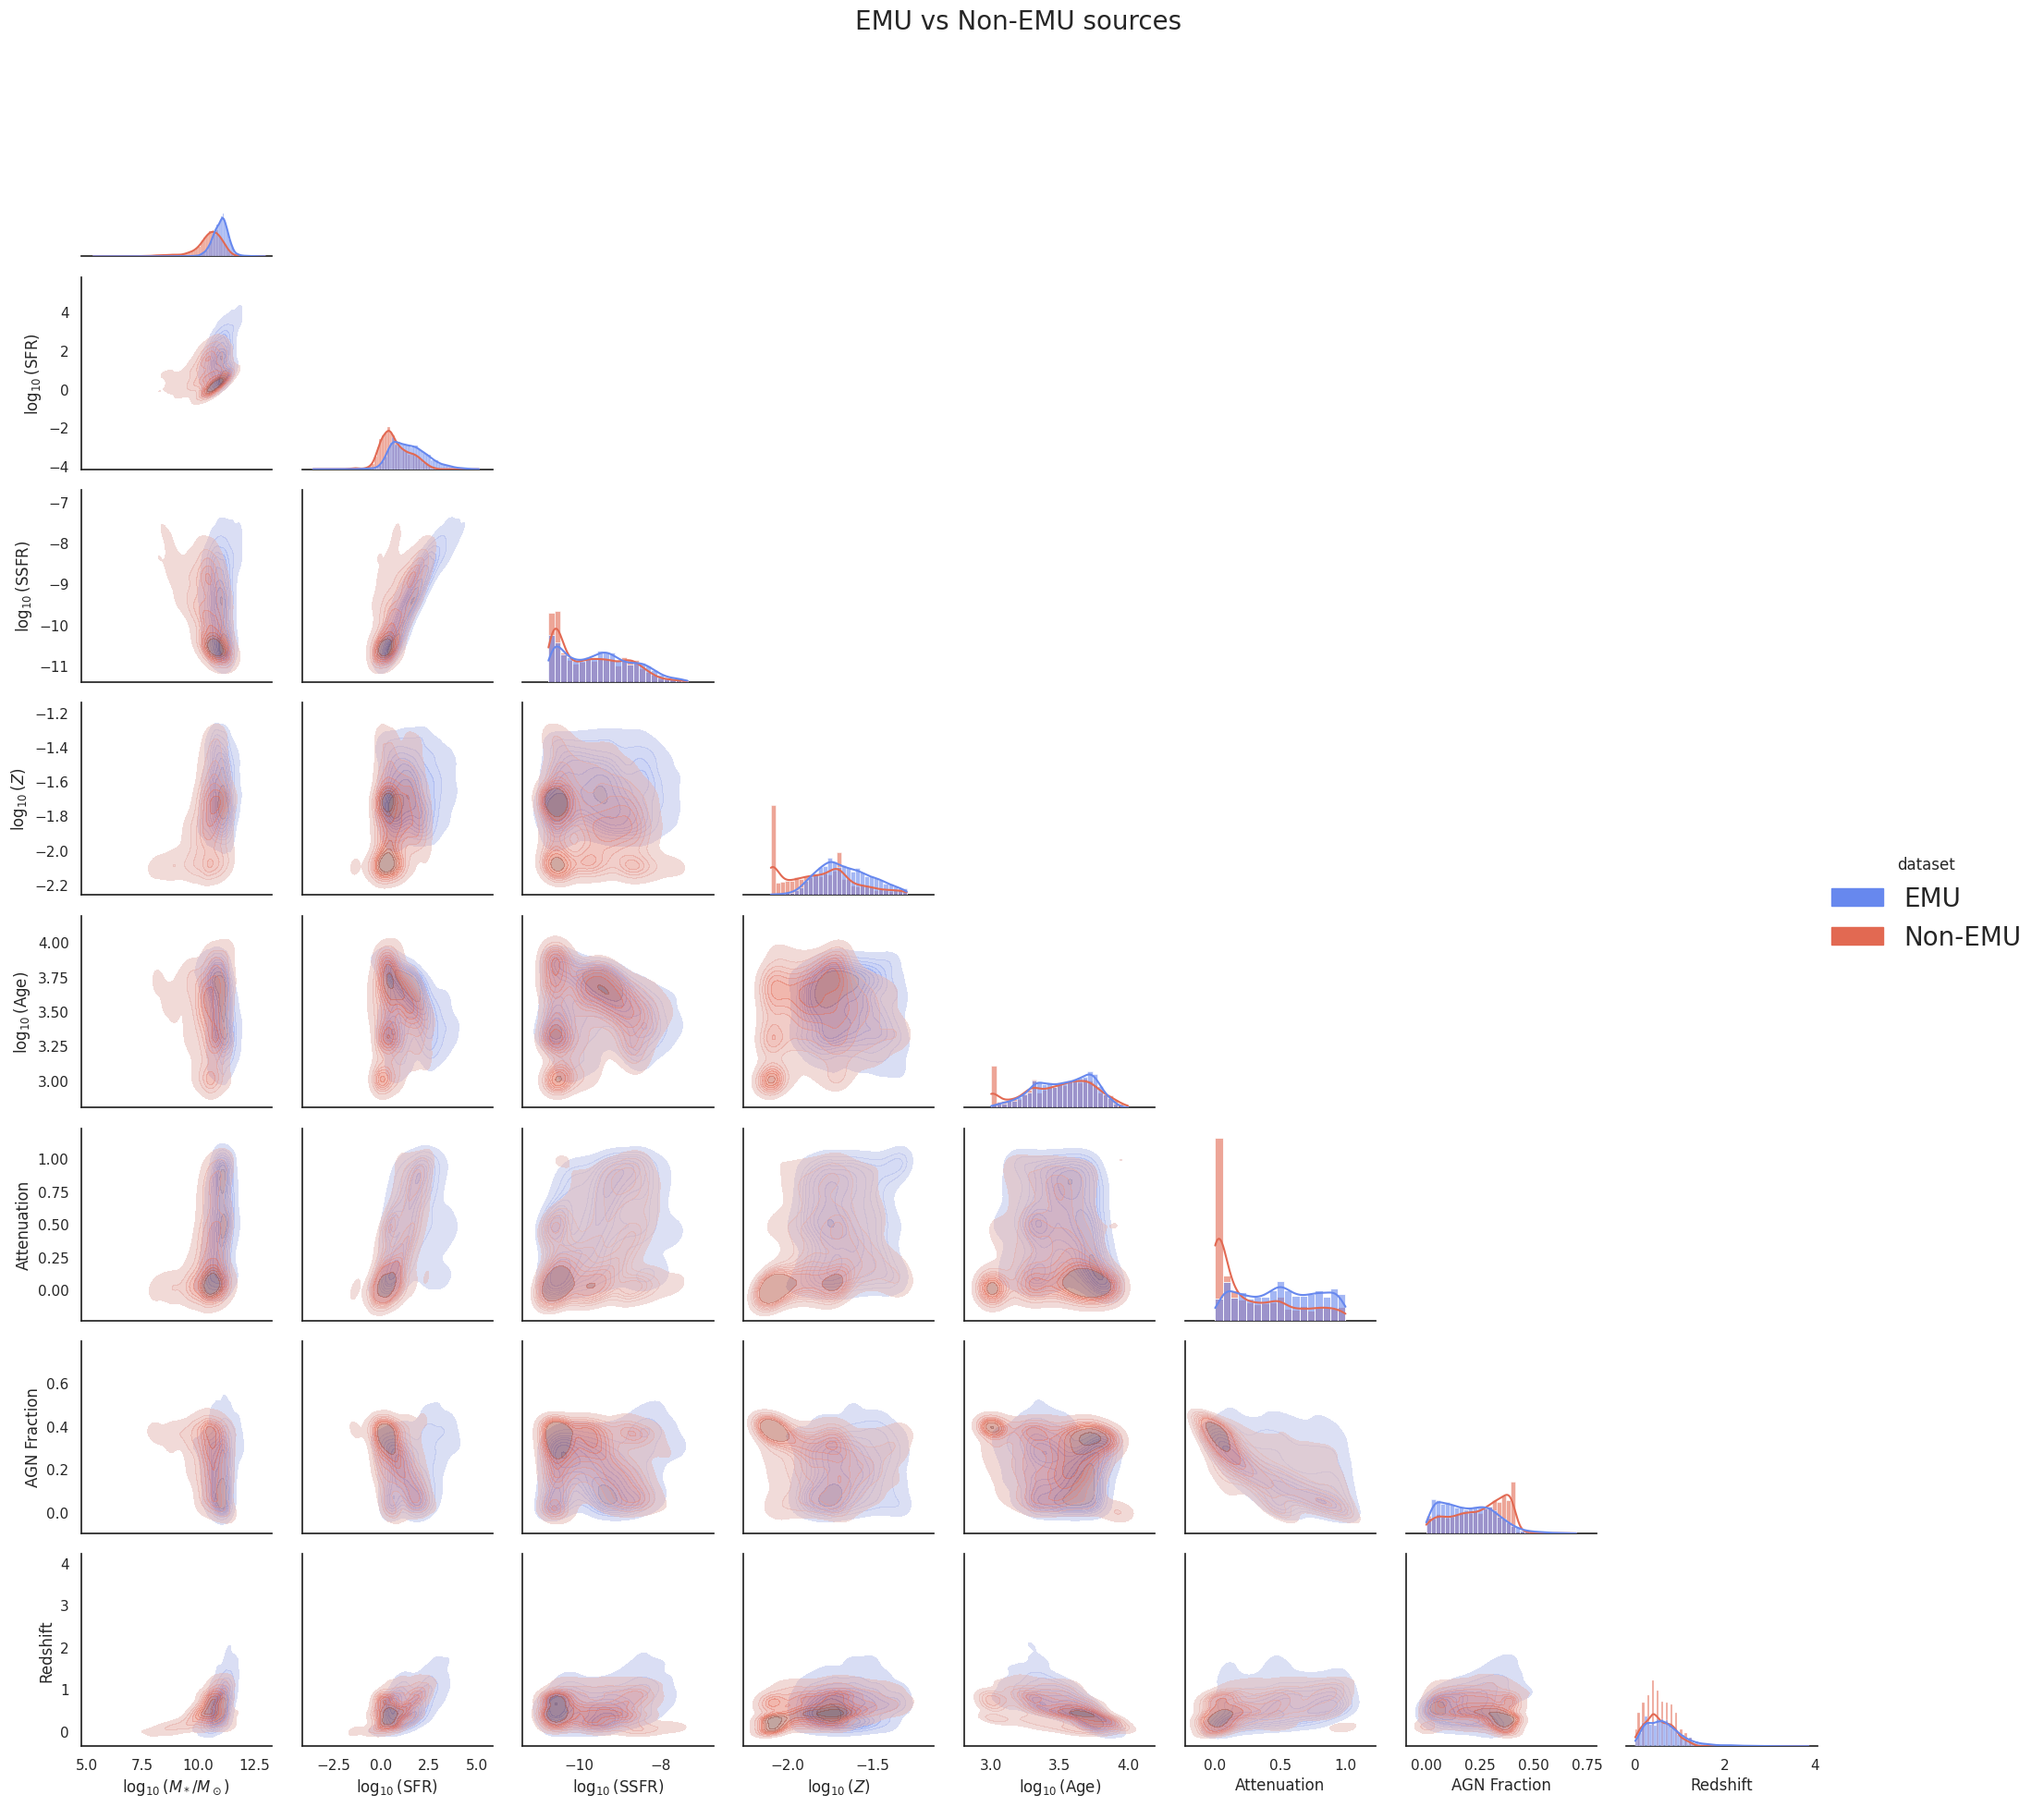

In [103]:
# Define properties
properties = [
    'log_stellar_mass', 'log_sfr', 'log_ssfr',
    'log_metallicity', 'log_age', 'bayes.attenuation.Av_BC',
    'bayes.agn.fracAGN', 'bayes.universe.redshift'
]

# Join the two dataframes and create a new column with the origin of the data
emu_sources_best['dataset'] = 'EMU'
nonemu_sources_best['dataset'] = 'Non-EMU'
joined_df = pd.concat([emu_sources_best, nonemu_sources_best], ignore_index=True)

# Axis label, already in the correct order and the same for vertical and horizontal
labels = [r'$\log_{10}(M_*/M_\odot)$', r'$\log_{10}(\mathrm{SFR})$', r'$\log_{10}(\mathrm{SSFR})$', r'$\log_{10}(Z)$', r'$\log_{10}(\mathrm{Age})$',r'Attenuation', r'AGN Fraction', r'Redshift']

# Create the PairGrid
g = sns.PairGrid(joined_df, vars=properties, hue='dataset', corner=True, palette=custom_palette)

# Lower triangle: KDE
g.map_lower(sns.kdeplot, fill=True, alpha=0.5, thresh=0.05)

# Diagonal: Histogram
g.map_diag(sns.histplot, kde=True, alpha=0.6)

# Add legend
g.add_legend(fontsize=20)

# Set the axis labels
for ax, label in zip(g.axes[-1,:], labels):  # For x-axis labels
    ax.set_xlabel(label)
for ax, label in zip(g.axes[:,0], labels):  # For y-axis labels
    ax.set_ylabel(label)

# Overall title
plt.subplots_adjust(top=0.95)
g.fig.suptitle('EMU vs Non-EMU sources', fontsize=20)

plt.show()

### Histogram of EMU and non-EMU sources

In [78]:
def plot_log_hist_percent_2rows_sns(
    df1, df2, columns, x_labels, legend_positions, 
    labels, titles, values1, values2, errors1, errors2, figsize=(25, 10), bins=50
):

    n = len(columns)
    nrows = 2
    ncols = math.ceil(n / nrows)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)

    for i, col in enumerate(columns):
        row = i // ncols
        col_idx = i % ncols
        ax = axes[row, col_idx]
        
        data1 = df1[col]
        data2 = df2[col]

        if ('bayes.agn.fracAGN' in col) or ('bayes.stellar.metallicity' in col) or ('bayes.universe.redshift' in col):
            # Linear scale
            ax.hist(
                data1,
                bins=bins,
                weights=np.ones_like(data1) * 100 / len(data1),
                alpha=0.5,
                label=labels[0],
                color='blue'
            )
            ax.hist(
                data2,
                bins=bins,
                weights=np.ones_like(data2) * 100 / len(data2),
                alpha=0.5,
                label=labels[1],
                color='red'
            )
            # Medians
            ax.axvline(data1.median(), color='blue', linestyle='dashed', linewidth=1.5, label= f'{values1[i]:.2f} ± {errors1[i]:.2f}')
            ax.axvline(data2.median(), color='red', linestyle='dashed', linewidth=1.5, label= f'{values2[i]:.2f} ± {errors2[i]:.2f}')

            ax.set_xlabel(x_labels[i])

        else:
            # Log scale
            data1 = data1[data1 > 0]
            data2 = data2[data2 > 0]
            min_val = min(data1.min(), data2.min())
            max_val = max(data1.max(), data2.max())
            log_bins = np.logspace(np.log10(min_val), np.log10(max_val), bins)

            ax.hist(
                data1,
                bins=log_bins,
                weights=np.ones_like(data1) * 100 / len(data1),
                alpha=0.5,
                label=labels[0],
                color='blue'
            )
            ax.hist(
                data2,
                bins=log_bins,
                weights=np.ones_like(data2) * 100 / len(data2),
                alpha=0.5,
                label=labels[1],
                color='red'
            )
            ax.set_xscale('log')
            ax.set_xlabel(x_labels[i])

            # Means (log scale plots)
            ax.axvline(data1.median(), color='blue', linestyle='dashed', linewidth=1.5, label= f'10^({values1[i]:.2f} ± {errors1[i]:.2f})')
            ax.axvline(data2.median(), color='red', linestyle='dashed', linewidth=1.5, label= f'10^({values2[i]:.2f} ± {errors2[i]:.2f})')

        ax.set_title(titles[i])
        ax.set_ylabel('Percentage of Sources [%]')
        ax.legend(loc=legend_positions[i])

    # Hide unused subplots
    for j in range(n, nrows * ncols):
        row = j // ncols
        col_idx = j % ncols
        axes[row, col_idx].axis('off')

    plt.tight_layout()
    plt.savefig("/home/polaris/Lab_Astro/cigale.png", dpi=72)
    plt.show()

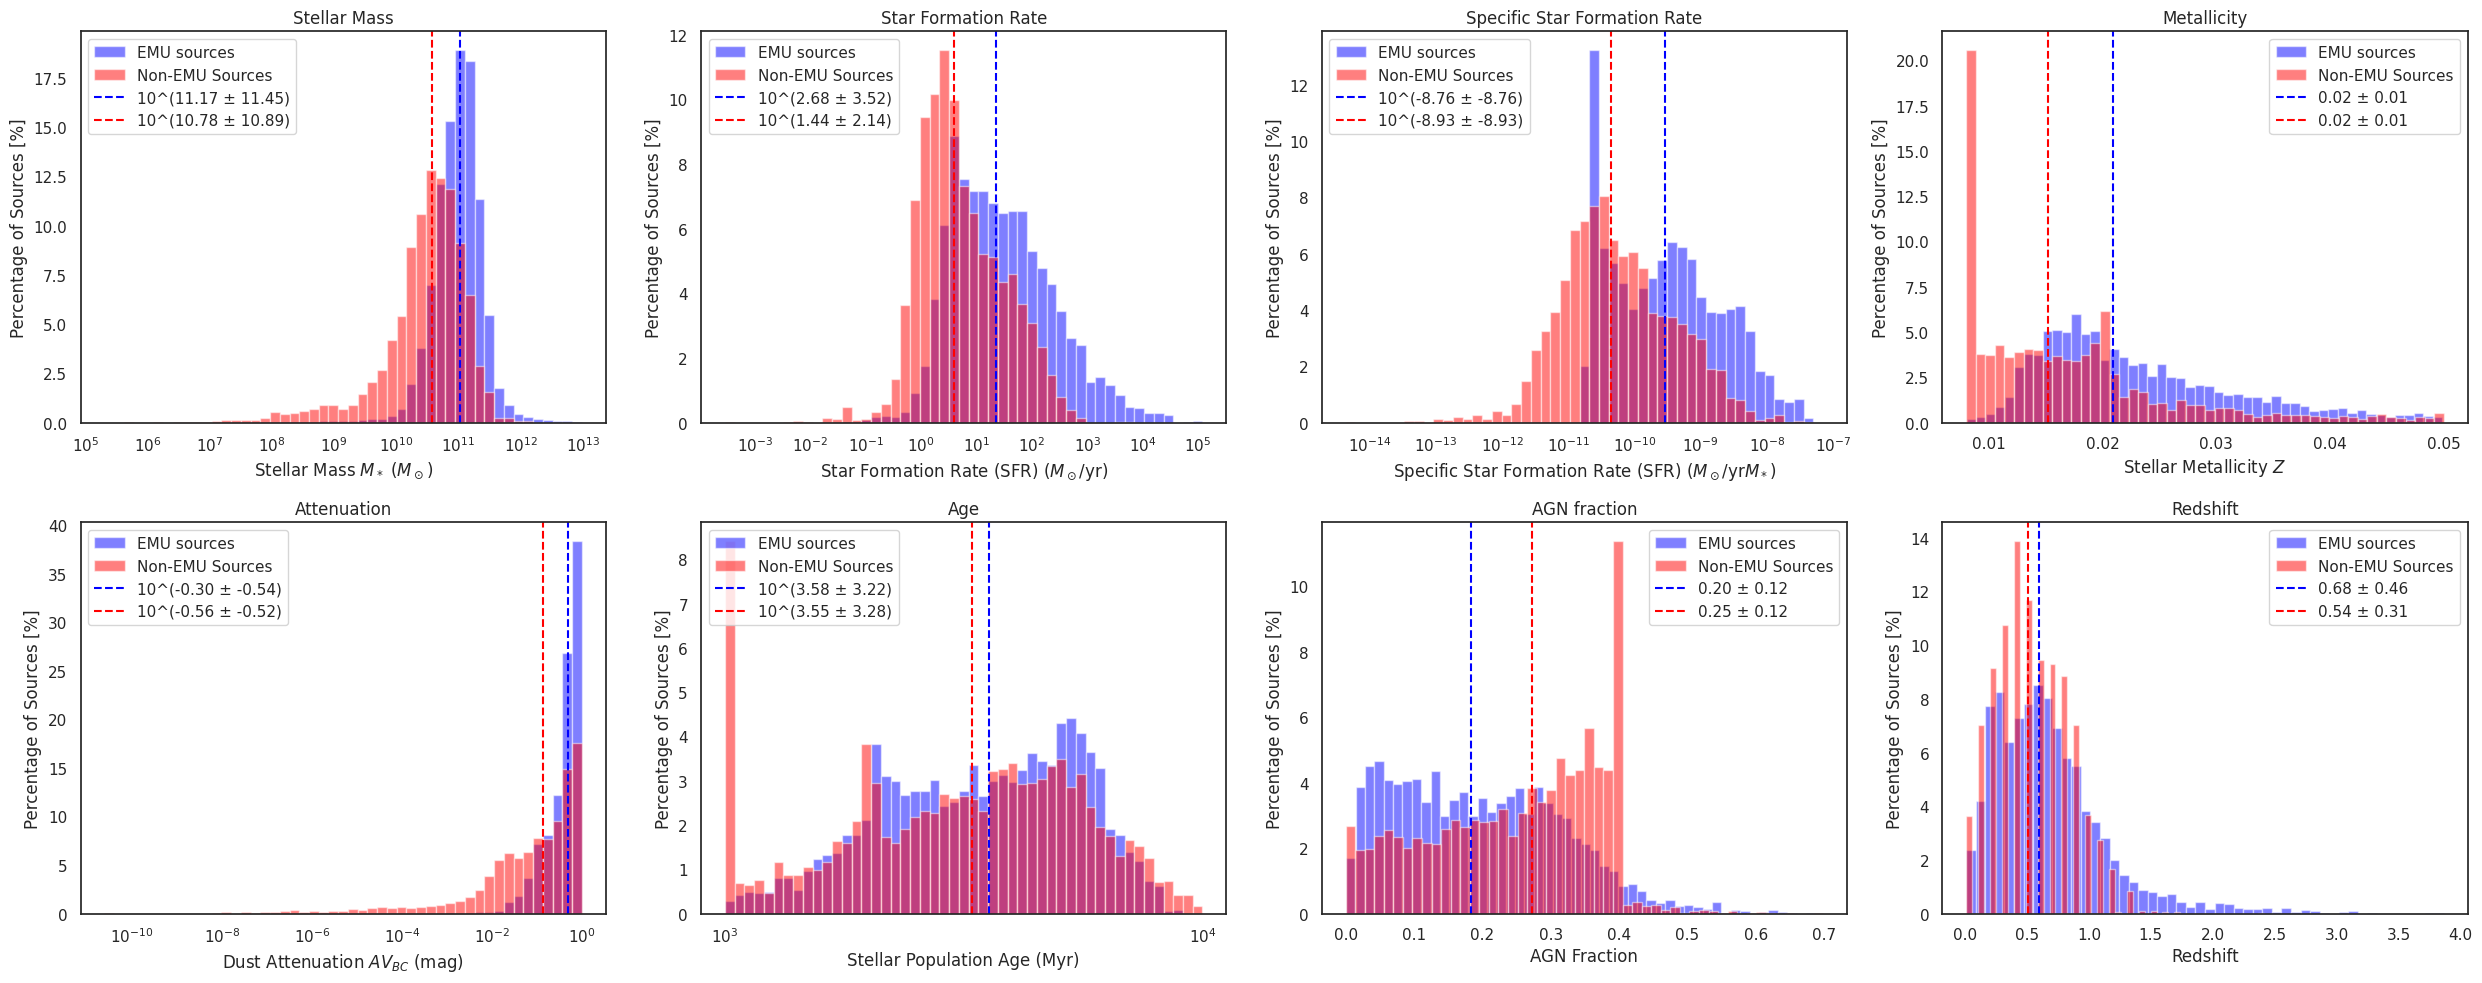

In [79]:
plot_log_hist_percent_2rows_sns(
    df1=emu_sources_best,
    df2=nonemu_sources_best,
    columns=[
        'bayes.stellar.m_star', 'bayes.sfh.sfr', 'bayes.sfh.sfr_permass','bayes.stellar.metallicity',
        'bayes.attenuation.Av_BC', 'bayes.sfh.age', 'bayes.agn.fracAGN', 'bayes.universe.redshift'
    ],
    x_labels=[
        r"Stellar Mass $M_*$ ($M_\odot$)",
        r"Star Formation Rate (SFR) ($M_\odot$/yr)",
        r"Specific Star Formation Rate (SFR) ($M_\odot$/yr$M_*$)",
        r"Stellar Metallicity $Z$",
        r"Dust Attenuation $AV_{BC}$ (mag)",
        r"Stellar Population Age (Myr)",
        r"AGN Fraction",
        r"Redshift"
    ],
    labels=("EMU sources", "Non-EMU Sources"),
    legend_positions= ['upper left', 'upper left', 'upper left', 'upper right','upper left','upper left','upper right','upper right' ],
    titles = ['Stellar Mass', 'Star Formation Rate', 'Specific Star Formation Rate', 'Metallicity', 'Attenuation', 'Age', 'AGN fraction', 'Redshift'],
    values1=[np.log10(emu_avg_stellarmass), np.log10(emu_avg_sfr), np.log10(emu_avg_ssfr), emu_avg_metallicity, np.log10(emu_avg_Av_BC), np.log10(emu_avg_age), emu_avg_AGN, emu_avg_red],
    errors1=[np.log10(emu_err_stellarmass), np.log10(emu_err_sfr), np.log10(emu_avg_ssfr), emu_err_metallicity, np.log10(emu_err_Av_BC), np.log10(emu_err_age), emu_err_AGN, emu_err_red],
    values2=[np.log10(avg_stellarmass), np.log10(avg_sfr), np.log10(avg_ssfr), avg_metallicity, np.log10(avg_Av_BC), np.log10(avg_age), avg_AGN, avg_red],
    errors2=[np.log10(err_stellarmass), np.log10(err_sfr), np.log10(avg_ssfr), err_metallicity, np.log10(err_Av_BC), np.log10(err_age), err_AGN, err_red]
)

In [ ]:
plot_log_hist_percent_2rows_sns(
    df1=emu_sources_best,
    df2=nonemu_sources_best,
    columns=[
        'bayes.stellar.m_star', 'bayes.sfh.sfr_permass', 'bayes.stellar.metallicity',
        'bayes.attenuation.Av_BC', 'bayes.sfh.age', 'bayes.agn.fracAGN'
    ],
    x_labels=[
        r"Stellar Mass $M_*$ ($M_\odot$)",
        r"Specific Star Formation Rate (sSFR) ($M_\odot$/yr$M_*$)",
        r"Stellar Metallicity $Z$",
        r"Dust Attenuation $AV_{BC}$ (mag)",
        r"Stellar Population Age (Myr)",
        r"AGN Fraction",
    ],
    labels=("EMU sources", "Non-EMU Sources"),
    legend_positions= ['upper left', 'upper left','upper right','upper left','upper left','upper right' ],
    titles = ['Stellar Mass', 'Star Formation Rate', 'Metallicity', 'Attenuation', 'Age', 'AGN fraction']
)

TypeError: plot_log_hist_percent_2rows_sns() missing 4 required positional arguments: 'values1', 'values2', 'errors1', and 'errors2'

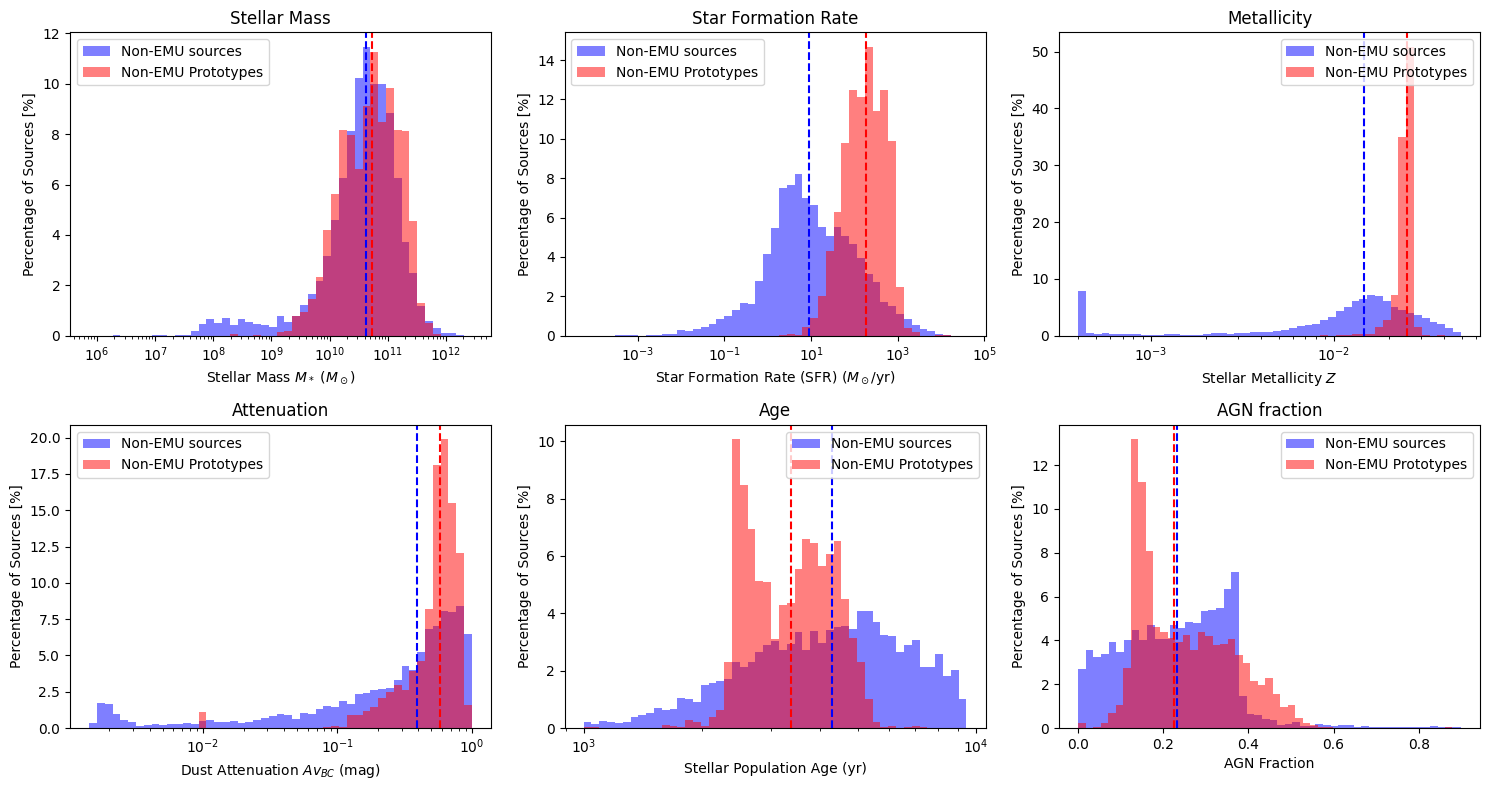

In [ ]:
plot_log_hist_percent_2rows_sns(
    df1=nonemu_sources_best,
    df2=nonemu_prototypes_best,
    columns=[
        'bayes.stellar.m_star', 'bayes.sfh.sfr', 'bayes.stellar.metallicity',
        'bayes.attenuation.Av_BC', 'bayes.sfh.age', 'bayes.agn.fracAGN'
    ],
    x_labels=[
        r"Stellar Mass $M_*$ ($M_\odot$)",
        r"Star Formation Rate (SFR) ($M_\odot$/yr)",
        r"Stellar Metallicity $Z$",
        r"Dust Attenuation $Av_{BC}$ (mag)",
        r"Stellar Population Age (yr)",
        r"AGN Fraction"
    ],
    labels=("Non-EMU sources", "Non-EMU Prototypes"),
    legend_positions= ['upper left', 'upper left','upper right','upper left','upper right','upper right' ],
    titles = ['Stellar Mass', 'Star Formation Rate', 'Metallicity', 'Attenuation', 'Age', 'AGN fraction']
)

### Density plot of EMU and non-EMU sources

In [ ]:
def plot_log_kde_2rows_sns(df1, df2, columns, x_labels, legend_positions, labels=("DF1", "DF2"), figsize=(15, 8)):
    """
    Plot KDE (density) curves using Seaborn for specified columns from two DataFrames in 2 rows.
    Uses log scaling on axes where appropriate.

    Parameters:
    - df1, df2: pandas DataFrames
    - columns: list of column names to plot (must exist in both)
    - x_labels: list of x-axis labels (same length as columns)
    - labels: tuple of legend labels for df1 and df2
    - figsize: tuple for figure size
    """
    n = len(columns)
    nrows = 2
    ncols = math.ceil(n / nrows)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)

    for i, col in enumerate(columns):
        row = i // ncols
        col_idx = i % ncols
        ax = axes[row, col_idx]
        
        data1 = df1[col].dropna()
        data2 = df2[col].dropna()

        if 'bayes.agn.fracAGN' in col:
            # Linear scale
            sns.kdeplot(data1, ax=ax, label=labels[0], color='blue', fill=True, common_norm=False)
            sns.kdeplot(data2, ax=ax, label=labels[1], color='red', fill=True, common_norm=False)
        else:
            # Log scale (filter > 0)
            data1 = data1[data1 > 0]
            data2 = data2[data2 > 0]
            sns.kdeplot(np.log10(data1), ax=ax, label=labels[0], color='blue', fill=True, common_norm=False)
            sns.kdeplot(np.log10(data2), ax=ax, label=labels[1], color='red', fill=True, common_norm=False)
            ax.set_xlabel(x_labels[i] + " (log₁₀)")
            ax.set_xticks(np.arange(np.floor(np.log10(data1.min())), np.ceil(np.log10(data1.max())) + 1))
            ax.set_xticklabels([f"$10^{int(x)}$" for x in ax.get_xticks()])
            ax.set_xlim(left=np.log10(min(data1.min(), data2.min())))

        ax.set_title(col)
        ax.set_ylabel('Density')
        ax.legend(loc = legend_positions[i])

    # Hide unused subplots
    for j in range(n, nrows * ncols):
        row = j // ncols
        col_idx = j % ncols
        axes[row, col_idx].axis('off')

    plt.tight_layout()
    plt.show()

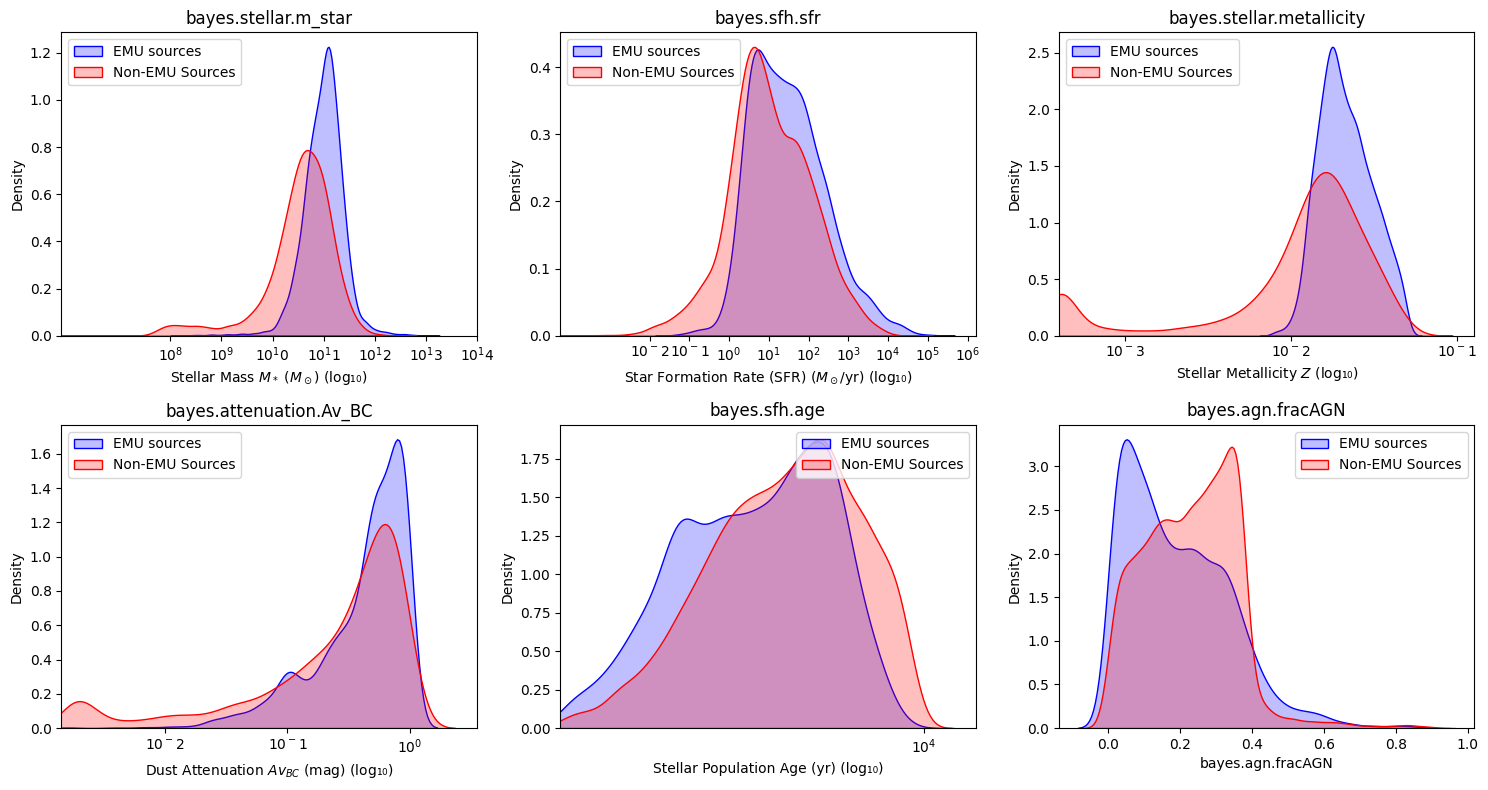

In [ ]:
plot_log_kde_2rows_sns(
    df1=emu_sources_best,
    df2=nonemu_sources_best,
    columns=[
        'bayes.stellar.m_star', 'bayes.sfh.sfr', 'bayes.stellar.metallicity',
        'bayes.attenuation.Av_BC', 'bayes.sfh.age', 'bayes.agn.fracAGN'
    ],
    x_labels=[
        r"Stellar Mass $M_*$ ($M_\odot$)",
        r"Star Formation Rate (SFR) ($M_\odot$/yr)",
        r"Stellar Metallicity $Z$",
        r"Dust Attenuation $Av_{BC}$ (mag)",
        r"Stellar Population Age (yr)",
        r"AGN Fraction",
    ],
    labels=("EMU sources", "Non-EMU Sources"),
    legend_positions= ['upper left', 'upper left','upper left','upper left','upper right','upper right' ]
)

## Compare Prototype Values with BMUs of those prototypes

Plot the prototype distribution and the 2 BMUs distributions